- gungu, dong 으로 segment -> test에만 있는 값이 있는지 확인

# Library Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [2]:
gc_collect_all()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import datetime
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def return_unique_columns(data):
    unique_info = data.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    return unique_cols

In [5]:
class CFG:
    SEED = 42
    SUBSET_DEPTH = 3
    N_SPLITS = 5
    TARGET = 'ECLO'
    TARGET_TRANSFORMATION = 'identity'

<br></br>

# Data

## Data Load

In [6]:
tr_df = pd.read_csv('./data/train.csv')

In [7]:
train_df = pd.concat([
    pd.read_csv('./data/train.csv'),
    pd.read_csv('./data/external_open/countrywide_accident.csv',encoding='utf-8'),
],axis=0).reset_index(drop=True)
test_df  = pd.read_csv('./data/test.csv')

# cctv_df = pd.read_csv('./data/external_open/대구 CCTV 정보.csv',encoding='cp949')
# security_light_df = pd.read_csv('./data/external_open/대구 보안등 정보.csv',encoding='cp949',low_memory=False)
# child_zone_df = pd.read_csv('./data/external_open/대구 어린이 보호 구역 정보.csv',encoding='cp949')
# parking_df = pd.read_csv('./data/external_open/대구 주차장 정보.csv',encoding='cp949')

In [8]:
display(train_df.head(1))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5


<br>

## Preprocessing

In [9]:
def add_week(weekend):
    week = 1
    week_list = []
    for weekend in weekend:
        if weekend==1:
            week+=1
        week_list.append(week)
    return week_list

def split_location(location):
    error_return = [np.nan,np.nan,np.nan]
    
    if location is np.nan:
        return error_return
    splited = location.split(' ')
    if len(splited)==4:
        splited = splited[1:]
    elif len(splited)==2:
        return error_return
    
    sido, gungu, dong = splited
    return [sido,gungu,dong]

def preprocessing(data):
    d = data.copy()
    
    # (1) test data에 없는 컬럼 제거
    no_columns_in_test = ['사고유형 - 세부분류','법규위반','가해운전자 차종','가해운전자 성별','가해운전자 연령',
                          '가해운전자 상해정도','피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도']
    no_columns_in_test = list(set(d.columns)&set(no_columns_in_test))
    d.drop(no_columns_in_test,axis=1,inplace=True)
    
    # (1) 시군구: 시/군구/동 -> 군구/동
    d[['sido','gungu','dong']] = np.stack(d['시군구'].apply(split_location))
    d.drop('시군구',axis=1,inplace=True)
    
    # (2) 도로형태
    d[['roadtype','roadtype_detail']] = np.stack(d['도로형태'].str.split(' - '))
    d['is_parking'] = d['roadtype'].map({'단일로':0,'교차로':0,'기타':np.nan,'주차장':1,'미분류':np.nan})
    d['is_road']    = d['roadtype'].map({'단일로':1,'교차로':1,'기타':np.nan,'주차장':np.nan,'미분류':np.nan})
    d.drop('도로형태',axis=1,inplace=True)
    for col in ['is_parking','is_road']:
        d[col] = d[col].fillna(0)

    return d

def feature_engineering(data):
    d = data.copy()
    date = d['사고일시'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d %H'))
    
    # (1) date columns
    d['year']       = date.dt.year
    d['month']      = date.dt.month
    d['day']        = date.dt.day
    d['hour']       = date.dt.hour
    d['weekday']    = date.dt.weekday
    d['weekend']    = date.dt.weekday.isin([5,6]).astype(int)
    d['week']       = add_week(d['weekend'])

    # (2) is holiday & is dayoff
    holiday_list = get_holiday(d['year'].unique())
    d['is_holiday'] = date.isin(holiday_list).astype(int)
    d['is_dayoff']  = ((d.is_holiday==1) | (d.weekend==1)).astype(int)
    
    # (3) unuse features
    unuse_features = ['ID','사고일시','요일','사망자수','중상자수','경상자수','부상자수']
    unuse_features = list(set(d.columns)&set(unuse_features))
    d.drop(columns=unuse_features,inplace=True)
    
    return d

In [10]:
train_df = preprocessing(train_df)
train_df = feature_engineering(train_df)

test_df = preprocessing(test_df)
test_df = feature_engineering(test_df)

tr_df = preprocessing(tr_df)
tr_df = feature_engineering(tr_df)

In [11]:
train_df.dropna(subset=['노면상태'],inplace=True)

In [12]:
train_df.head(2)

,기상상태,노면상태,사고유형,ECLO,sido,gungu,dong,roadtype,roadtype_detail,is_parking,is_road,year,month,day,hour,weekday,weekend,week,is_holiday,is_dayoff
0,맑음,건조,차대사람,5,대구광역시,중구,대신동,단일로,기타,0.0,1.0,2019,1,1,0,1,0,1,1,1
1,흐림,건조,차대사람,3,대구광역시,달서구,감삼동,단일로,기타,0.0,1.0,2019,1,1,0,1,0,1,1,1


<br>

## Merge Addtional Information

In [13]:
def add_cctv_info(data):
    d = data.copy()

    cctv_df = pd.read_csv('./data/external_open/대구 CCTV 정보.csv',encoding='cp949')

    # 다사읍 -> 다사읍동
    cctv_df['소재지지번주소'] = cctv_df['소재지지번주소'].str.replace(' 다사읍 ',' 다사읍동 ')

    # 수기로 수정 (1)
    raw = ['대구광역시 다사읍동 세천리 1684-4','대구광역시 가창면 삼산리 산 327-9']
    new = ['대구광역시 달성군 다사읍동 세천리 1684-4','대구광역시 달성군 가창면 삼산리 산 327-9']
    for r,n in zip(raw,new):
        loc = cctv_df['소재지지번주소'] == r
        cctv_df.loc[loc, '소재지지번주소'] = n

    # 수기로 수정 (2)
    raw = ['대구광역시 중구 종로 17','대구광역시 중구 국채보상로 713']
    new = ['대구 중구 남성로동 92','대구 중구 동인동4가 89-1']
    for r,n in zip(raw,new):
        loc = (cctv_df['소재지지번주소'].isnull()) & (cctv_df['소재지도로명주소']==r)
        cctv_df.loc[loc, '소재지지번주소'] = n

    cctv_df[['gungu','dong']] = [[np.nan,np.nan] if address is np.nan else
                                 split_location(' '.join(address.split(' ')[:3]))
                                 for address in cctv_df['소재지지번주소']]

    # 단속구분별 cctv 수
    for v in [1,2,4]:
        colname = f'n_cctv_단속구분{v}'
        sub = cctv_df[cctv_df['단속구분']==v]
        n_cctv = sub.groupby(['gungu','dong']).size().reset_index().rename(columns={0:colname})
        d = pd.merge(d,n_cctv,how='left',on=['gungu','dong'])
        d[colname].fillna(0,inplace=True)

    # 도로노선방향별 cctv 수
    for v in [1,2,3]:
        colname = f'n_cctv_도로노선방향{v}'
        sub = cctv_df[cctv_df['도로노선방향']==v]
        n_cctv = sub.groupby(['gungu','dong']).size().reset_index().rename(columns={0:colname})
        d = pd.merge(d,n_cctv,how='left',on=['gungu','dong'])
        d[colname].fillna(0,inplace=True)

    # 'n_cctv_도로노선방향3', 'n_cctv_단속구분4'는 correlation이 100%임
    d.drop('n_cctv_도로노선방향3',axis=1,inplace=True)

    # 제한속도 최소/최대/평균
    tmp = cctv_df[cctv_df['제한속도']!=0]
    limit_speed = tmp\
        .groupby(['gungu','dong'])['제한속도']\
        .agg(min=np.nanmin,max=np.nanmax,avg=np.nanmean)\
        .add_prefix('limit_speed_')\
        .reset_index()
    d = pd.merge(d,limit_speed,how='left',on=['gungu','dong'])
    limit_speed_maximum = d['limit_speed_max'].max()
    limit_speed_cols = ['limit_speed_min','limit_speed_max','limit_speed_avg']
    for col in limit_speed_cols:
        d[col].fillna(limit_speed_maximum,inplace=True)

    # 설치연도 최소/최대/평균
    installation_year = cctv_df\
        .groupby(['gungu','dong'])['설치연도']\
        .agg(min=np.nanmin,max=np.nanmax,avg=np.nanmean)\
        .add_prefix('installation_year_')\
        .reset_index()
    d = pd.merge(d,installation_year,how='left',on=['gungu','dong'])
    installation_year_minimum = d['installation_year_min'].min()
    installation_cols = ['installation_year_min','installation_year_max','installation_year_avg']
    for col in installation_cols:
        d[col].fillna(installation_year_minimum,inplace=True)

    # 보호구역구분: 1,2인 경우 보호구역으로 보고, 나머지(99,nan)는 보호구역이 아닌 것으로 봄
    cctv_df['is_protectzone'] = np.where(cctv_df['보호구역구분'].isin([1,2]),1,0)
    protectzone = cctv_df.groupby(['gungu','dong'])['is_protectzone'].agg(n_protectzone=np.nansum).reset_index()
    d = pd.merge(d,protectzone,how='left',on=['gungu','dong'])
    d['n_protectzone'].fillna(0,inplace=True)
    
    # # delete features
    # del_features = ['limit_speed_min','limit_speed_max','installation_year_min','installation_year_max']
    # d.drop(del_features,axis=1,inplace=True)
    
    return d

In [14]:
# train_df = add_cctv_info(train_df)
# test_df  = add_cctv_info(test_df)

In [15]:
# train_df.head(2)

<br>

## Target Transformation

In [16]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION, offset=0)
train_df[CFG.TARGET] = target_transform.fit_transform(train_df[CFG.TARGET])

In [17]:
tr_df[CFG.TARGET] = target_transform.transform(tr_df[CFG.TARGET])

<br>

## Quantile values of Target

In [18]:
cat_features = ['기상상태','노면상태','사고유형','sido','gungu','dong','roadtype','roadtype_detail']

In [19]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=CFG.TARGET,
    cat_features=setdiff(cat_features,['dong']),
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df = calculator.transform(train_df)
test_df  = calculator.transform(test_df)
tr_df    = calculator.transform(tr_df)

> Get quantiles of target by categorical features (depth=3)


Subset: gungu + roadtype + roadtype_detail: 100%|█| 63/63 [00:17<00:00,  3.67it/


In [20]:
del calculator

<br>

## Group Scaler

In [21]:
# num_features = train_df.drop(cat_features,axis=1)
# num_features = setdiff(num_features,[CFG.TARGET])

In [22]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = GroupScaler(scaler=MinMaxScaler())
# scaler.fit(
#     data=train_df,
#     group='gungu',
#     num_features=num_features,
# )
# train_df = scaler.transform(train_df)
# test_df  = scaler.transform(test_df)

<br>

## Memory Reduce

In [23]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)
tr_df , _ = reduce_mem_usage(tr_df ,verbose=False)

<br></br>

# Modeling

In [24]:
# https://dacon.io/en/codeshare/6499

In [25]:
from copy import deepcopy
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, MultiTaskElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle
import dill

def RMSE(y_true, y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

def RMSLE(y_true, y_pred):
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    squared_error = (log_true-log_pred)**2
    return np.sqrt(np.mean(squared_error))

In [26]:
# 2) 업데이트버전
#  (1) stacking 추가
#  (2) LGBM에 sample_weight 추가
class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 method='ensemble',
                 use_weightedsum_in_stacking=True):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        assert method in ['ensemble','stacking'], \
            "method must be one of ['ensemble','stacking']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.method = method
        self.use_weightedsum_in_stacking = use_weightedsum_in_stacking
        
        self._get_regressors()
        self._get_regressors_name()
        
        if use_weightedsum_in_stacking:
            self.stacking_feature = 'pred'
        else:
            self.stacking_feature = [f'pred{i+1}' for i in range(len(self.regressors))]
            
    def _get_regressors(self):
        max_depth = 9
        n_jobs = -1
        cat_loss_function = 'RMSE' # 'RMSE','MAE','MultiRMSE'
        cat_eval_metric = 'RMSE'   # 'RMSE','MAE','MultiRMSE'
        lgb_metric = 'rmse' # 'rmse','mean_absolute_error'
        
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=self.hyperparameters['random_state'])
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : cv,
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : cv,
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : cv,
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : cat_loss_function,
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : cat_loss_function,
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : cat_loss_function,
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : cat_loss_function,
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_lightgbm1 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm2 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm3 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm4 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm5 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm6 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm7 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm8 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['xgb_iterations'],
            'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['xgb_learning_rate'],
            'objective' : 'reg:squarederror',#'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        # params_extratrees = {
        #     'random_state' : self.hyperparameters['random_state'],
        #     'n_estimators' : self.hyperparameters['extratrees_iterations'],
        #     'criterion' : 'absolute_error',
        #     'verbose' : 0,
        #     'max_depth' : self.hyperparameters['max_depth'],
        #     'n_jobs' : n_jobs,
        # }
        
        params_hgb = {
            'random_state' : self.hyperparameters['random_state'],
            'max_iter' : self.hyperparameters['hgb_iterations'],
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
        }
        
        params_rf = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['rf_iterations'],
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
        }
        
        self.regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm8),
            #RandomForestRegressor(**params_rf),
            #ExtraTreesRegressor(**params_extratrees),
            #HistGradientBoostingRegressor(**params_hgb),
        ]
        
        self.stacking_regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            #XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm8),
            #RandomForestRegressor(**params_rf),
            #ExtraTreesRegressor(**params_extratrees),
            #HistGradientBoostingRegressor(**params_hgb),
        ]
        
    def _get_regressors_name(self):
        self.regressors_name = [type(r).__name__ for r in self.regressors]
        self.stacking_regressors_name = [type(r).__name__ for r in self.stacking_regressors]
        
    def _get_ohe(self,X,cat_features):
        ohe = OneHotEncoder()
        ohe.fit(X,cat_features,remove_first=False)
        return ohe
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _preprocess(self,pred):
        # pred = self._set_zero_to_minimum(pred,self.minimum_value)
        # pred = self._set_inf_to_maximum(pred,self.maximum_value)
        return pred
    
    def _fit_regressor(self,
                       regressor,regressor_name,
                       features,oh_features,
                       X,X_oh,X_val,X_val_oh,y,y_val,cat_features,
                       sample_weight,eval_sample_weight):
        X = X[features]
        X_val = X_val[features]
        X_oh = X_oh[oh_features]
        X_val_oh = X_val_oh[oh_features]
        
        if (regressor_name in ['LinearRegression','RidgeCV','LassoCV']) or\
            (regressor_name.find('ExtraTreesRegressor')>=0) or\
            (regressor_name.find('RandomForestRegressor')>=0) or\
            (regressor_name.find('HistGradientBoostingRegressor')>=0) or\
            (regressor_name.find('ElasticNetCV')>=0):
            warnings.filterwarnings("ignore", category=UserWarning)
            # fitting
            regressor.fit(X_oh,y)
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh))
            va_pred = self._preprocess(regressor.predict(X_val_oh))

        elif regressor_name.find('XGBRegressor')>=0:
            # fitting
            regressor.fit(
                X_oh,y,
                eval_set=[(X_val_oh,y_val)],
                verbose=0,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh))
            va_pred = self._preprocess(regressor.predict(X_val_oh))

        elif regressor_name.find('CatBoostRegressor')>=0:
            # dataset
            train_dataset = Pool(X    ,y    ,cat_features=cat_features)
            val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
            # fitting
            regressor.fit(
                train_dataset,
                eval_set=val_dataset,
                #metric_period=self.hyperparameters['iterations']//50, verbose=True,
                verbose=False,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(train_dataset))
            va_pred = self._preprocess(regressor.predict(val_dataset))

        elif regressor_name.find('LGBMRegressor')>=0:
            warnings.filterwarnings("ignore", category=UserWarning)
            # astype category
            for col in cat_features:
                X[col]     = X[col]    .astype('category')
                X_val[col] = X_val[col].astype('category')
            # fitting
            regressor.fit(
                X,y,
                eval_set=[(X_val,y_val)],
                sample_weight=sample_weight,
                eval_sample_weight=eval_sample_weight,
                categorical_feature=cat_features,
                verbose=-1,
            )
            tr_pred = self._preprocess(regressor.predict(X))
            va_pred = self._preprocess(regressor.predict(X_val))
            # # fitting
            # regressor.fit(
            #     X_oh,y,
            #     eval_set=[(X_val_oh,y_val)],
            #     sample_weight=sample_weight,
            #     eval_sample_weight=eval_sample_weight,
            #     #categorical_feature=cat_features,
            #     verbose=-1,
            # )
            # tr_pred = self._preprocess(regressor.predict(X_oh))
            # va_pred = self._preprocess(regressor.predict(X_val_oh))
            
        else:
            raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
        return regressor, tr_pred, va_pred
            
    def _get_prediction_values(self,X,X_oh,method,regressors_name,regressors,weights,return_weighted):
        if method=='ensemble':
            features    = self.features
            oh_features = self.oh_features
        elif method=='stacking':
            stacking_feature = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            features    = self.features + stacking_feature
            oh_features = self.oh_features + stacking_feature
        
        # (1) 예측값생성
        pred_list = []
        for regressor_name,regressor in zip(regressors_name,regressors):
            if (regressor_name in ['LinearRegression','RidgeCV','LassoCV','ElasticNetCV','RandomForestRegressor']) or\
                (regressor_name.find('ExtraTreesRegressor')>=0) or\
                (regressor_name.find('RandomForestRegressor')>=0) or\
                (regressor_name.find('XGBRegressor')>=0) or\
                (regressor_name.find('HistGradientBoostingRegressor')>=0) or\
                (regressor_name.find('ElasticNetCV')>=0):
                dataset = X_oh[oh_features]
            elif regressor_name.find('CatBoostRegressor')>=0:
                dataset = Pool(X[features],cat_features=self.cat_features)
            elif regressor_name.find('LGBMRegressor')>=0:
                # dataset = X_oh[oh_features]
                dataset = X[features].copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = self._preprocess(regressor.predict(dataset))
            pred_list.append(y_pred)
        
        # (2) return weighted or original value
        if return_weighted:
            final_pred = []
            for pred,weight in zip(pred_list,weights):
                p = np.array(pred)*weight
                final_pred.append(p)
            final_pred = np.sum(final_pred,axis=0)
            if self.inverse_transform is not None:
                final_pred = self.inverse_transform(np.array(final_pred))
                final_pred = self._preprocess(final_pred)
        else:
            final_pred = np.array(pred_list).T
            
        return final_pred
        
    def _predict(self,X,method,return_weighted=True):
        if len(self.cat_features)>0:
            #X_oh = self.ohe.transform(X)
            X_oh = X.copy()
        else:
            X_oh = X.copy()
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        # (1) ensemble
        pred_list = self._get_prediction_values(
            X,X_oh,
            'ensemble',
            self.regressors_name,self.regressors,
            self.ensemble_weights,return_weighted,
        )
        
        if method=='ensemble':
            return pred_list
        
        elif method=='stacking':
            # (2) stacking
            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            pred_df = pd.DataFrame(pred_list,columns=columns,index=X.index)
            
            X    = pd.concat([X   ,pred_df],axis=1)
            X_oh = pd.concat([X_oh,pred_df],axis=1)

            pred_list = self._get_prediction_values(
                X,X_oh,
                'stacking',
                self.stacking_regressors_name,self.stacking_regressors,
                self.stacking_weights,return_weighted,
            )
            return pred_list
        
    def get_feature_importance(self):
        # message_print = warnings.warn
        message_print = print
        supported_models = self.regressors_name
        
        # # feature_importances_를 지원하는 모델들
        # supported_models = ['CatBoostRegressor','XGBRegressor','LGBMRegressor','ExtraTreesRegressor',
        #                     'ExtraTreesRegressor', 'RandomForestRegressor', 'HistGradientBoostingRegressor']

        # # 지원하지않는 모델이 있는 경우 warning message
        # not_supported_1 = len([name for name in self.regressors_name if name not in supported_models])
        # not_supported_2 = 0
        # for name in self.regressors_name:
        #     for m in supported_models:
        #         k = 0 if name.find(m)>=0 else 1
        #         not_supported_2 += k

        # if not_supported_1 + not_supported_2 > 0:
        #     message_print("not support model")

        # get weighted feature importance by using ensemble_weights
        feature_importance_df = pd.DataFrame(self.features,columns=['feature'])
        for i,(regressor,regressor_name,weight) in enumerate(zip(self.regressors,self.regressors_name,self.ensemble_weights)):
            if regressor_name in supported_models:
                feature_importance = regressor.feature_importances_
                fi_list = []
                for feature in self.features:
                    fi = feature_importance[np.where(np.array(self.features)==feature)[0]]
                    fi_list.append([feature,sum(fi)])

                imp_col = f'importance{i}'
                fi_df = pd.DataFrame(fi_list,columns=['feature',imp_col]).sort_values(imp_col,ascending=False)
                fi_df[imp_col] = 100 * fi_df[imp_col] / fi_df[imp_col].sum()
                fi_df[imp_col] *= weight

                feature_importance_df = pd.merge(feature_importance_df,fi_df,how='left',on='feature')

        feature_importance_df = feature_importance_df.fillna(0)
        feature_importance_df['importance'] = feature_importance_df.drop('feature',axis=1).sum(axis=1)
        feature_importance_df = feature_importance_df[['feature','importance']]
        
        return feature_importance_df
        
    def plot_feature_importance(self):
        feature_importance_df = self.get_feature_importance()
        feature_importance_df.sort_values('importance',ascending=True,inplace=True)
        plt.figure(figsize=(15,7))
        plt.barh(feature_importance_df['feature'],feature_importance_df['importance'])
        plt.show()
            
    def fit(self,
            X,y,eval_set,cat_features,
            sample_weight=None,eval_sample_weight=None,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        
        if len(self.regressors)!=len(self.regressors_name):
            self._get_regressors_name()
        
        self.sample_weight = sample_weight
        self.eval_sample_weight = eval_sample_weight
        self.cat_features = cat_features
        self.enable_categorical = [True if col in cat_features else False for col in X.columns]
        
        #----------------------------------------------------------------------------------------#
        # prepare dataset
        #----------------------------------------------------------------------------------------#
        X_val, y_val = eval_set[0]
        
        del_cols = return_unique_columns(X)
        X.drop(del_cols,axis=1,inplace=True)
        X_val.drop(del_cols,axis=1,inplace=True)
        self.cat_features = list(set(cat_features)-set(del_cols))
        
        if len(self.cat_features)>0:
            # self.ohe = self._get_ohe(X,cat_features)
            # X_oh = self.ohe.transform(X)
            # X_val_oh = self.ohe.transform(X_val)
            X_oh = X.copy()
            X_val_oh = X_val.copy()
        else:
            X_oh = X.copy()
            X_val_oh = X_val.copy()
        
        del_oh_cols = return_unique_columns(X_oh)
        X_oh.drop(del_oh_cols,axis=1,inplace=True)
        X_val_oh.drop(del_oh_cols,axis=1,inplace=True)
        
        #----------------------------------------------------------------------------------------#
        # save feature names
        #----------------------------------------------------------------------------------------#
        self.features    = X   .columns.tolist()
        self.oh_features = X_oh.columns.tolist()
        
        #----------------------------------------------------------------------------------------#
        # true value
        #----------------------------------------------------------------------------------------#
        tr_true = np.array(y)
        va_true = np.array(y_val)
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        #----------------------------------------------------------------------------------------#
        # set min,max value
        #----------------------------------------------------------------------------------------#
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        #----------------------------------------------------------------------------------------#
        # (1) ensemble fitting
        #----------------------------------------------------------------------------------------#
        # prepare ensemble fitting
        self.ensemble_scores = []
        self.ensemble_weights = []
        self.ensemble_fitting_elapsed = []
        ensemble_pbar = zip(self.regressors_name,self.regressors)

        # fitting
        if self.method=='stacking':
            if verbose:
                print('\n########  <Step1> Ensemble  ########')
        for fit_iter,(regressor_name,regressor) in enumerate(ensemble_pbar):
            s = time.time()
                
            # fit
            regressor, tr_pred, va_pred = self._fit_regressor(
                regressor, regressor_name,
                self.features,self.oh_features,
                X, X_oh, X_val, X_val_oh, y, y_val, self.cat_features,
                sample_weight, eval_sample_weight,
            )
            self.regressors[fit_iter] = regressor
            
            # progress
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                tr_pred = self._preprocess(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                va_pred = self._preprocess(va_pred)
            
            tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
            va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)
            
            e = time.time()
            self.ensemble_scores.append(va_score)
            self.ensemble_weights.append(1/va_score)
            self.ensemble_fitting_elapsed.append(e-s)
            
            if verbose:
                blank = ' '*(11-len(regressor_name))
                fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                    .format(fit_iter+1,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
                print(fit_progress)
            
        # get weighted prediction & score
        if self.weight=='equal':
            self.ensemble_weights = np.array([1.0 for _ in self.regressors])
        self.ensemble_weights /= sum(self.ensemble_weights)
        
        tr_pred = self._predict(X,method='ensemble',return_weighted=True)
        va_pred = self._predict(X_val,method='ensemble',return_weighted=True)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)
        
        if verbose:
            ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                .format(self.weight,ens_tr_score,ens_va_score,sum(self.ensemble_fitting_elapsed))
            print(ens_fit_progress)
        
        if self.method=='ensemble':
            self.total_score = ens_va_score
            
        elif self.method=='stacking':
            #----------------------------------------------------------------------------------------#
            # (2) stacking fitting
            #----------------------------------------------------------------------------------------#
            tr_pred = self._predict(X,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)
            va_pred = self._predict(X_val,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)

            stacking_columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            tr_pred_df = pd.DataFrame(tr_pred,columns=stacking_columns,index=X.index)
            va_pred_df = pd.DataFrame(va_pred,columns=stacking_columns,index=X_val.index)
            
            X        = pd.concat([X       ,tr_pred_df],axis=1)
            X_oh     = pd.concat([X_oh    ,tr_pred_df],axis=1)
            X_val    = pd.concat([X_val   ,va_pred_df],axis=1)
            X_val_oh = pd.concat([X_val_oh,va_pred_df],axis=1)

            # prepare stacking fitting
            self.stacking_scores = []
            self.stacking_weights = []
            self.stacking_fitting_elapsed = []

            stacking_regressors = deepcopy(self.stacking_regressors)
            stacking_pbar = zip(self.stacking_regressors_name,stacking_regressors)

            if verbose:
                print('\n########  <Step2> Stacking  ########')
            self.stacking_regressors = []
            for fit_iter,(regressor_name,regressor) in enumerate(stacking_pbar):
                s = time.time()

                # fitting
                stacking_regressor, tr_pred, va_pred = self._fit_regressor(
                    regressor, regressor_name,
                    self.features+stacking_columns,self.oh_features+stacking_columns,
                    X, X_oh, X_val, X_val_oh, y, y_val, self.cat_features,
                    sample_weight, eval_sample_weight,
                )
                self.stacking_regressors.append(stacking_regressor)

                # progress
                if self.inverse_transform is not None:
                    tr_pred = self.inverse_transform(tr_pred)
                    tr_pred = self._preprocess(tr_pred)
                    va_pred = self.inverse_transform(va_pred)
                    va_pred = self._preprocess(va_pred)

                tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
                va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)

                e = time.time()
                self.stacking_scores.append(va_score)
                self.stacking_weights.append(1/va_score)
                self.stacking_fitting_elapsed.append(e-s)

                if verbose:
                    blank = ' '*(11-len(regressor_name))
                    iter_str = str(fit_iter+1).zfill(len(str(len(stacking_regressors))))
                    fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                        .format(iter_str,len(stacking_regressors),regressor_name,blank,tr_score,va_score,e-s)
                    print(fit_progress)

            # get weighted prediction & score
            if self.weight=='equal':
                self.stacking_weights = np.array([1.0 for _ in self.stacking_regressors])
            self.stacking_weights /= sum(self.stacking_weights)

            tr_pred = self._predict(
                X.drop(self.stacking_feature,axis=1),
                method='stacking',
                return_weighted=True,
            )
            va_pred = self._predict(
                X_val.drop(self.stacking_feature,axis=1),
                method='stacking',
                return_weighted=True,
            )

            ## -> self.predict에서 inverse_transform 해줌
            # if self.inverse_transform is not None:
            #     tr_pred = self.inverse_transform(tr_pred)
            #     va_pred = self.inverse_transform(va_pred)

            stacking_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
            stacking_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)

            if verbose:
                stacking_fit_progress = "<Weighted Stacking(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                    .format(self.weight,stacking_tr_score,stacking_va_score,sum(self.stacking_fitting_elapsed))
                print(stacking_fit_progress)

            self.total_score = stacking_va_score
            
        #self.feature_importances_ = self.get_feature_importance()['importance'].values.tolist()

    def predict(self,X,method=None):
        if method is None:
            method = self.method
        if (self.method=='ensemble') & (method=='stacking'):
            raise ValueError("The training method is 'ensemble', so 'stacking' prediction is not possible")
        return self._predict(X,method=self.method,return_weighted=self.use_weightedsum_in_stacking)
        
    def save(self,path):
        save_dict = {
            #'ohe' : self.ohe,
            'cat_features' : self.cat_features,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'sample_weight' : self.sample_weight,
            'eval_sample_weight' : self.eval_sample_weight,
            'regressors' : self.regressors,
            'ensemble_weights' : self.ensemble_weights,
            'ensemble_fitting_elapsed' : self.ensemble_fitting_elapsed,
            'ensemble_scores' : self.ensemble_scores,
            'total_score' : self.total_score,
            #'feature_importances_' : self.feature_importances_,
        }
        if self.method=='stacking':
            additional_save_dict = {
                'stacking_regressors' : self.stacking_regressors,
                'stacking_weights' : self.stacking_weights,
                'stacking_fitting_elapsed' : self.stacking_fitting_elapsed,
                'stacking_scores' : self.stacking_scores,
            }
            save_dict = {**save_dict,**additional_save_dict}
        with open(path, 'wb') as f:
            #pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            dill.dump(save_dict, f)
            
    def load(self,path):
        with open(path, 'rb') as f:
            #save_dict = pickle.load(f)
            save_dict = dill.load(f)
            #self.ohe = save_dict['ohe']
            self.cat_features = save_dict['cat_features']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.sample_weight = save_dict['sample_weight']
            self.eval_sample_weight = save_dict['eval_sample_weight']
            self.regressors = save_dict['regressors']
            self.ensemble_weights = save_dict['ensemble_weights']
            self.ensemble_fitting_elapsed = save_dict['ensemble_fitting_elapsed']
            self.ensemble_scores = save_dict['ensemble_scores']
            self.total_score = save_dict['total_score']
            #self.feature_importances_ = save_dict['feature_importances_']
            
            if self.method=='stacking':
                self.stacking_regressors = save_dict['stacking_regressors']
                self.stacking_weights = save_dict['stacking_weights']
                self.stacking_fitting_elapsed = save_dict['stacking_fitting_elapsed']
                self.stacking_scores = save_dict['stacking_scores']

In [27]:
class KfoldWeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 method='ensemble',
                 weight='balanced',
                 use_weightedsum_in_stacking=True,
                 inverse_transform=None,
                 eval_metric=None,
                 n_splits=5,
                 random_state=0):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.method = method
        self.weight = weight
        self.use_weightedsum_in_stacking = use_weightedsum_in_stacking
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.n_splits = n_splits
        self.random_state = random_state
        
    def get_feature_importance(self):
        fs = [m.features for m in self.base_models]
        fs = list(set(item for sublist in fs for item in sublist))
        feature_importance_df = pd.DataFrame(fs,columns=['feature'])

        for i,(base_model,base_feature_importance) in enumerate(zip(self.base_models,self.base_feature_importances)):
            imp_col = f'imp{i}'
            imp_df = pd.DataFrame({
                'feature' : base_model.features,
                imp_col : base_feature_importance,
            })
            feature_importance_df = pd.merge(feature_importance_df,imp_df,how='left',on='feature')

        feature_importance_df.fillna(0,inplace=True)
        feature_importance_df['importance'] = feature_importance_df.drop('feature',axis=1).sum(axis=1)
        feature_importance_df['importance'] = 100 * feature_importance_df['importance'] / feature_importance_df['importance'].sum()
        
        return feature_importance_df
        
    def plot_feature_importance(self):
        feature_importance_df = self.get_feature_importance()
        feature_importance_df.sort_values('importance',ascending=True,inplace=True)

        plt.figure(figsize=(15,7))
        plt.barh(feature_importance_df.feature,feature_importance_df.importance)
        plt.show()
        
    def fit(self,X,y,cat_features,sample_weight=None,verbose=True):
        self.cat_features = cat_features
        self.sample_weight = sample_weight
        self.features = X.columns.tolist()

        self.base_models = []
        self.base_scores = []
        self.base_feature_importances = []
        kf = KFold(n_splits=self.n_splits,random_state=self.random_state,shuffle=True)

        progress_fmt = '> KFold: {}/{}'
        for k, (tr_idx, val_idx) in enumerate(kf.split(X)):
            k_str = str(k+1).zfill(len(str(self.n_splits)))
            print('')
            print('-'*80)
            print(progress_fmt.format(k_str,self.n_splits))
            print('-'*80)
            
            X_tr, X_va = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]
            
            if self.sample_weight is None:
                sample_weight = None
                eval_sample_weight = None
            else:
                sample_weight = self.sample_weight[tr_idx]
                eval_sample_weight = self.sample_weight[val_idx]

            #------------------------------------------------------------------------------------#
            # (1) base model
            #------------------------------------------------------------------------------------#
            # define the base model
            base_model = WeightedEnsembleRegressor(
                hyperparameters,
                weight='balanced', # 'equal','balanced',
                inverse_transform=self.inverse_transform,
                eval_metric=self.eval_metric,
                method=self.method, # 'ensemble','stacking'
                use_weightedsum_in_stacking=self.use_weightedsum_in_stacking,
            )
            # fit the model
            base_model.fit(
                X_tr,y_tr,
                eval_set=[(X_va,y_va)],
                cat_features=cat_features,
                sample_weight=sample_weight,
                eval_sample_weight=[eval_sample_weight],
                verbose=verbose,
            )
            
            # prediction
            y_pred = base_model.predict(X_va)
            if self.inverse_transform is not None:
                y_true = self.inverse_transform(y_va.values)
            else:
                y_true = y_va.values
            
            # caculate score
            score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

            # append inner loop
            self.base_models.append(base_model)
            self.base_scores.append([k+1,len(X_tr),len(X_va),score])
            
            # # plot feature importance
            # self.base_feature_importances.append(base_model.feature_importances_)
            # base_model.plot_feature_importance()
        
        self.base_score = pd.DataFrame(self.base_scores,columns=['k','n_train','n_val','rmse'])
        self.validation_score = self.base_score.rmse.mean()
        
        #self.plot_feature_importance()
        
    def predict(self,X):
        pred = [base_model.predict(X) for base_model in self.base_models]
        pred = np.mean(pred,axis=0)
        return pred
    
    def save(self,path):
        save_dict = {
            'hyperparameters' : self.hyperparameters,
            'weight' : self.weight,
            'n_splits' : self.n_splits,
            'random_state' : self.random_state,
            'inverse_transform' : self.inverse_transform,
            'cat_features' : self.cat_features,
            'sample_weight' : self.sample_weight,
            'base_models' : self.base_models,
            'base_scores' : self.base_scores,
            'base_score' : self.base_score,
            'validation_score' : self.validation_score,
            'base_feature_importances' : self.base_feature_importances,
        }
        with open(path, 'wb') as f:
            #pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            dill.dump(save_dict, f)
            
    def load(self,path):
        with open(path, 'rb') as f:
            #save_dict = pickle.load(f)
            save_dict = dill.load(f)
            
            self.hyperparameters = save_dict['hyperparameters']
            self.weight = save_dict['weight']
            self.n_splits = save_dict['n_splits']
            self.random_state = save_dict['random_state']
            self.inverse_transform = save_dict['inverse_transform']
            self.cat_features = save_dict['cat_features']
            self.sample_weight = save_dict['sample_weight']
            self.base_models = save_dict['base_models']
            self.base_scores = save_dict['base_scores']
            self.base_score = save_dict['base_score']
            self.validation_score = save_dict['validation_score']
            self.base_feature_importances = save_dict['base_feature_importances']

In [28]:
hyperparameters = {
    'max_depth' : 9,
    'random_state' : CFG.SEED,
    'learning_rate' : 0.01,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.1,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'rf_iterations' : 100,
    'hgb_iterations' : 100,            # default=100
    #'extratrees_iterations' : 100,    # default=100
}

In [29]:
mc_path = './mc/weiens_model_additional_data.pkl'

In [30]:
X = train_df.drop(CFG.TARGET,axis=1)
y = train_df[CFG.TARGET]
X_test = test_df.copy()

X_tr = tr_df.drop(CFG.TARGET,axis=1)
y_tr = tr_df[CFG.TARGET]

unique_info = X.nunique()
unique_cols = unique_info[unique_info==1].index.tolist()
if len(unique_cols)>0:
    print(f'delete unique columns: {unique_cols}')
    X.drop(unique_cols,axis=1,inplace=True)
    X_test.drop(unique_cols,axis=1,inplace=True)
    X_tr.drop(unique_cols,axis=1,inplace=True)

delete unique columns: ['기상상태_Q25', '노면상태_Q25', 'sido_Q25', 'roadtype_Q25', 'roadtype_Q50']


In [ ]:
%%time

model = KfoldWeightedEnsembleRegressor(
    hyperparameters,
    method='stacking', #'ensemble',
    weight='balanced',
    use_weightedsum_in_stacking=True,
    inverse_transform=target_transform.inverse_transform,
    eval_metric=RMSLE,
    n_splits=CFG.N_SPLITS,
    random_state=CFG.SEED,
)
model.fit(
    X,y,
    cat_features=cat_features,
    sample_weight=None,
    verbose=True,
)
model.save(mc_path)

In [31]:
model = KfoldWeightedEnsembleRegressor(
    hyperparameters,
    method='stacking', #'ensemble',
    weight='balanced',
    use_weightedsum_in_stacking=True,
    inverse_transform=target_transform.inverse_transform,
    eval_metric=RMSLE,
    n_splits=CFG.N_SPLITS,
    random_state=CFG.SEED,
)
model.load(mc_path)

In [32]:
tr_prediction = model.predict(X)
te_prediction = model.predict(test_df)

check_prediction = model.predict(X_tr)

In [33]:
# identity, ensemble : RMSE: 2.975, RMSLE: 0.437
# log, ensemble      : RMSE: 3.095, RMSLE: 0.424
# log, stacking      : RMSE: 2.934, RMSLE: 0.388
true = target_transform.inverse_transform(y).flatten()
pred = tr_prediction.flatten()

print('RMSE: {:.3f}, RMSLE: {:.3f}'.format(RMSE(y_true=true,y_pred=pred),RMSLE(y_true=true,y_pred=pred)))

RMSE: 3.416, RMSLE: 0.445


In [34]:
true = target_transform.inverse_transform(y_tr).flatten()
pred = check_prediction.flatten()

print('RMSE: {:.3f}, RMSLE: {:.3f}'.format(RMSE(y_true=true,y_pred=pred),RMSLE(y_true=true,y_pred=pred)))

RMSE: 3.113, RMSLE: 0.457


In [39]:
from graph import abline, actual_prediction_scatterplot

ImportError: cannot import name 'actual_prediction_scatterplot' from 'graph' (/Volumes/KHJ/Github/hyuckjinkim/lib-python/graph.py)

In [64]:
def actual_prediction_scatterplot(y_true,y_pred,title=None):
    if title is None:
        rmse = np.mean((y_true-y_pred)**2)**0.5
        title = 'RMSE={:.3f}'.format(rmse)
    
    offset = 0.05
    xylim = (np.min([y_true,y_pred])*(1-offset),np.max([y_true,y_pred])*(1+offset))
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=y_true,y=y_pred)
    abline(0,1)
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.xlim(xylim)
    plt.ylim(xylim)
    plt.grid()
    plt.title(title)
    plt.show()

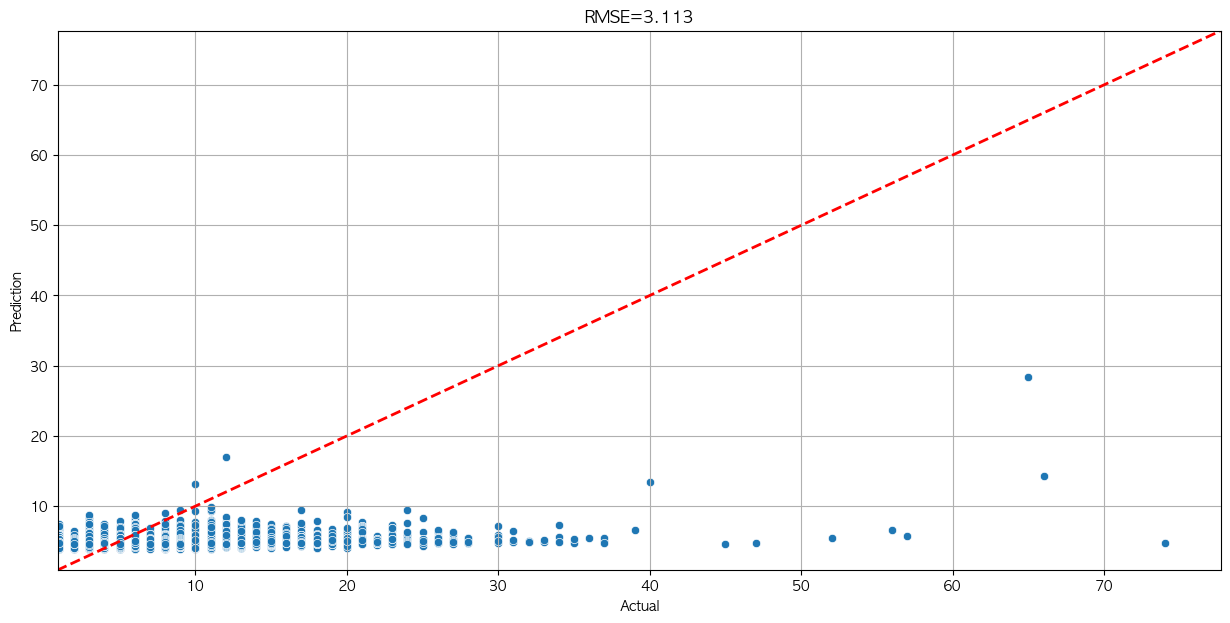

In [65]:
# rmse = RMSE(y_true=true,y_pred=pred)
actual_prediction_scatterplot(true,pred)

In [ ]:
# 0.4407124795
submit = pd.read_csv('./data/sample_submission.csv')
submit['ECLO'] = te_prediction
submit.to_csv('./out/9_weiens_log_stacking.csv',index=False)
submit.head()